# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [3]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization tools
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score

# Inline plotting for notebooks
%matplotlib inline

# Optional: show all columns in outputs
pd.set_option('display.max_columns', None)



## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [ ]:
# Load the dataset
df = pd.read_csv("porter_data_1.csv")  # make sure the CSV is in the same folder as your notebook

# Display first 5 rows
df.head()

# Check shape of the dataset
print("Dataset shape:", df.shape)

# Check column names
print("Columns:", df.columns.tolist())
# Importing the file porter_data_1.csv


Dataset shape: (175777, 14)
Columns: ['market_id', 'created_at', 'actual_delivery_time', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']


## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [ ]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
# Convert timestamp columns to datetime
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'], errors='coerce')

# Check conversion
df[['created_at', 'actual_delivery_time']].head()


,created_at,actual_delivery_time
0,2015-02-06 22:24:17,2015-02-06 23:11:17
1,2015-02-10 21:49:25,2015-02-10 22:33:25
2,2015-02-16 00:11:35,2015-02-16 01:06:35
3,2015-02-12 03:36:46,2015-02-12 04:35:46
4,2015-01-27 02:12:36,2015-01-27 02:58:36


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [ ]:
# Convert categorical features to category type

# List of categorical columns
categorical_fields = ['market_id', 'store_primary_category', 'order_protocol']

# Convert to category type
for feature in categorical_fields:
    df[col] = df[col].astype('category')

# Verify conversion
df[categorical_columns].dtypes

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [ ]:
# Calculate delivery time in minutes
df['delivery_time_minutes'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Check the first few values
df[['created_at', 'actual_delivery_time', 'delivery_time_minutes']].head()



,created_at,actual_delivery_time,delivery_time_minutes
0,2015-02-06 22:24:17,2015-02-06 23:11:17,47.0
1,2015-02-10 21:49:25,2015-02-10 22:33:25,44.0
2,2015-02-16 00:11:35,2015-02-16 01:06:35,55.0
3,2015-02-12 03:36:46,2015-02-12 04:35:46,59.0
4,2015-01-27 02:12:36,2015-01-27 02:58:36,46.0


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [ ]:
# Extract the hour and day of week from the 'created_a# Check the new features
df[['created_at', 'order_hour', 'order_day_of_week', 'isWeekend']].head()



,created_at,order_hour,order_day_of_week,isWeekend
0,2015-02-06 22:24:17,22,4,0
1,2015-02-10 21:49:25,21,1,0
2,2015-02-16 00:11:35,0,0,0
3,2015-02-12 03:36:46,3,3,0
4,2015-01-27 02:12:36,2,1,0


In [ ]:
# Drop unnecessary columns
df.drop(columns=['created_at', 'actual_delivery_time'], inplace=True)

# Check remaining columns
df.columns


#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [ ]:
# Define target variable (y) and features (X)
# Target variable
y = df['delivery_time_minutes']

# Feature matrix (drop the target column)
X = df.drop(['delivery_time_minutes'], axis=1)

# Check shapes
print("Features shape:", X.shape)
print("Target shape:", y.shape)



Features shape: (175777, 15)
Target shape: (175777,)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [ ]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check shapes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (140621, 15)
X_test: (35156, 15)
y_train: (140621,)
y_test: (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation
# Numerical columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical columns
cat_cols = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)



Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']
Categorical columns: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

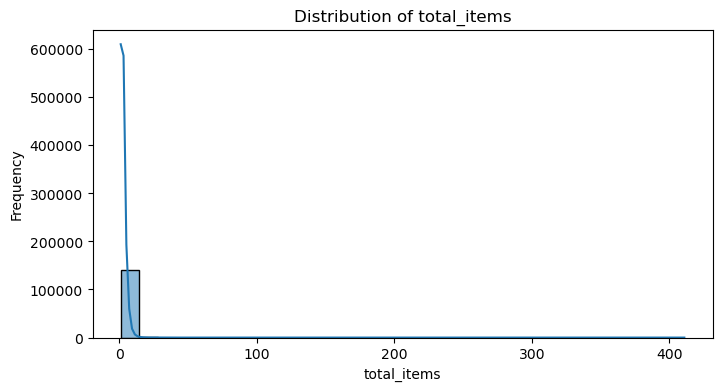

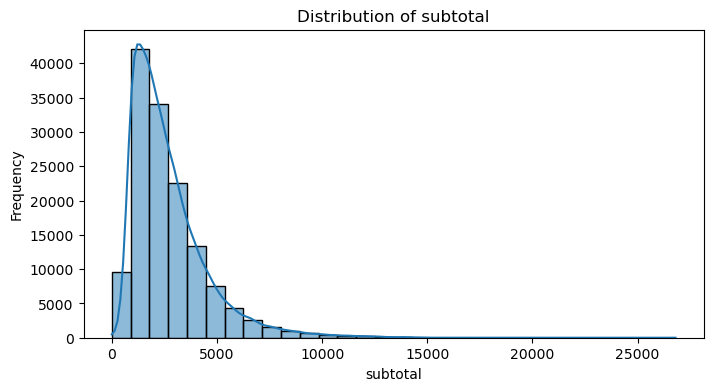

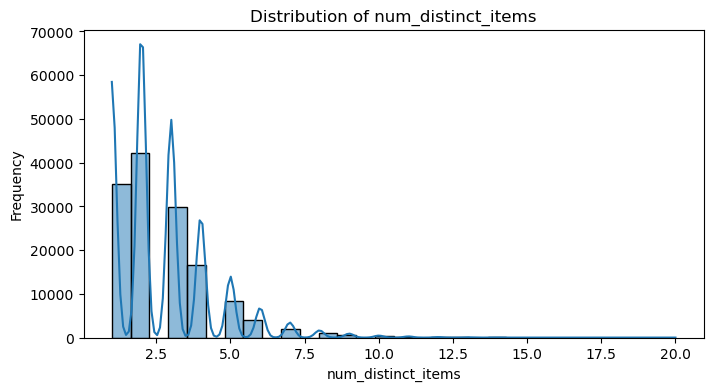

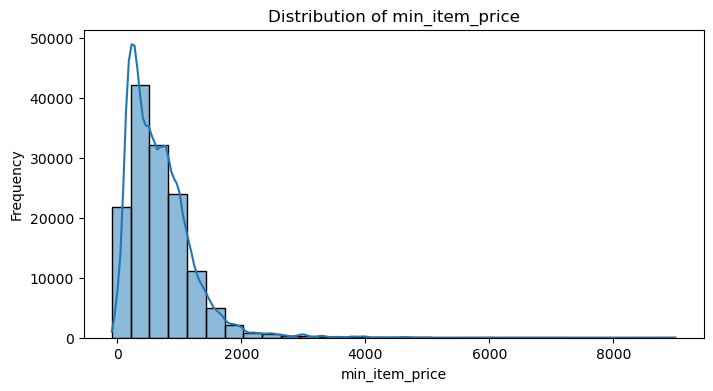

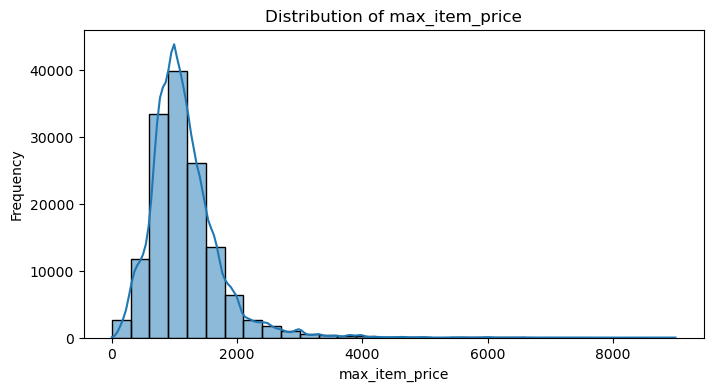

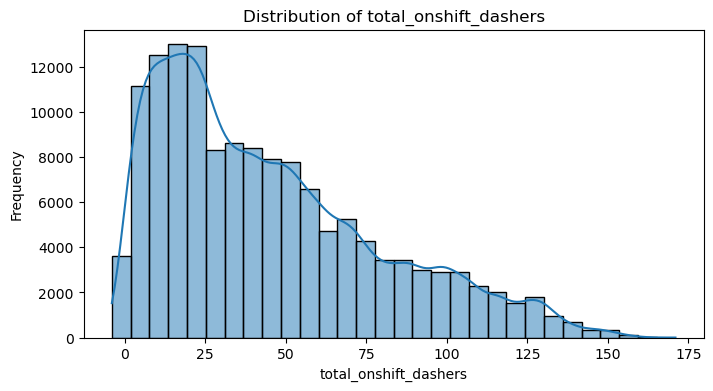

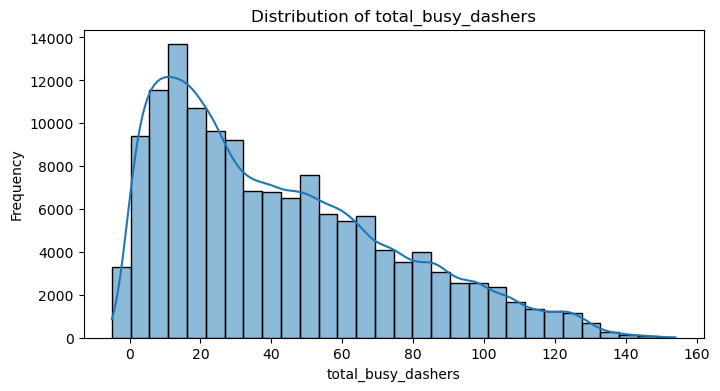

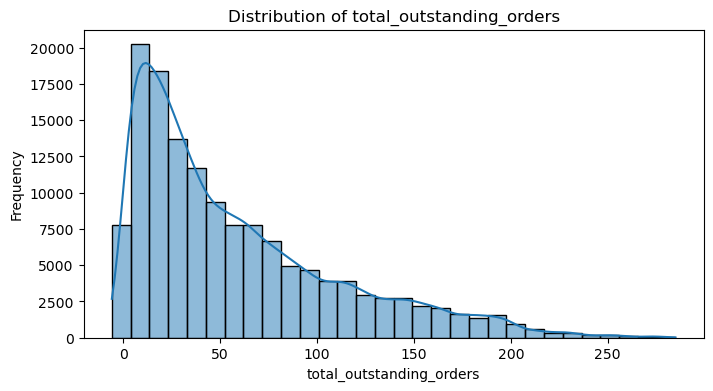

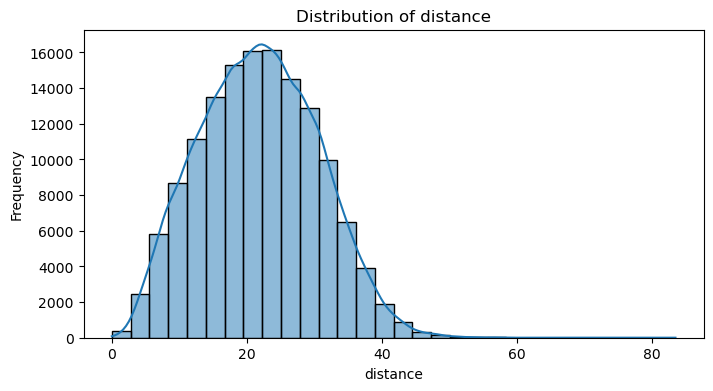

In [ ]:
# Plot distributions for all numerical columns
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distributions for numerical columns
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(X_train[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()



##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

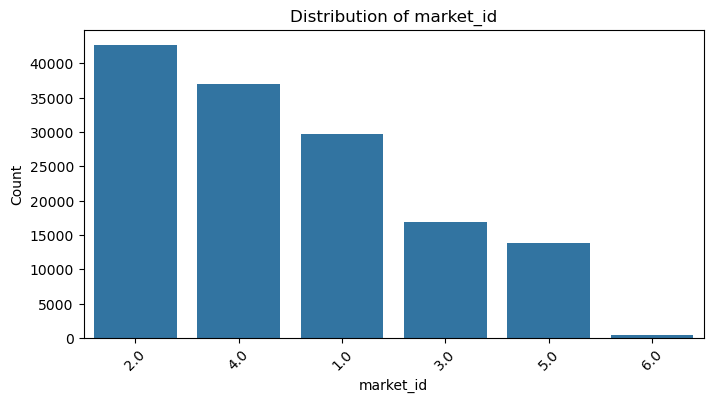

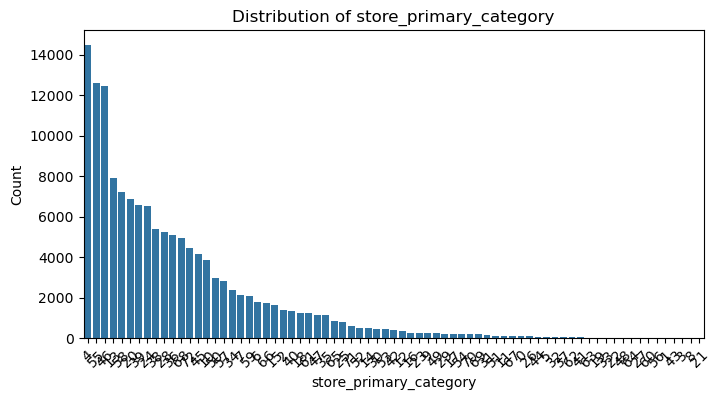

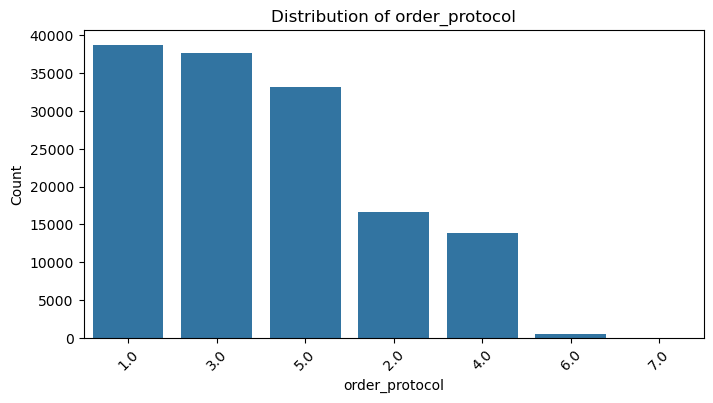

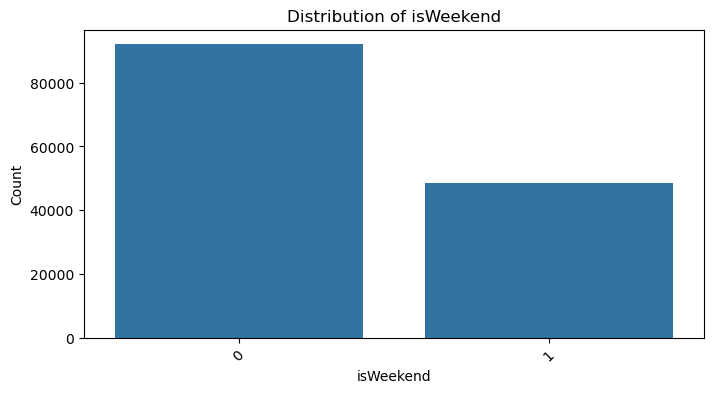

In [ ]:
# Distribution of categorical columns
# Plot distributions for categorical columns
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=X_train, x=col, order=X_train[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()



##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

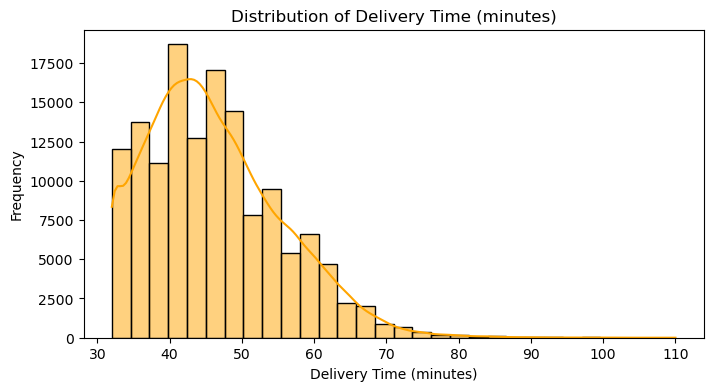

In [ ]:
# Distribution of time_taken
plt.figure(figsize=(8, 4))
sns.histplot(y_train, kde=True, bins=30, color='orange')
plt.title('Distribution of Delivery Time (minutes)')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Frequency')
plt.show()



#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

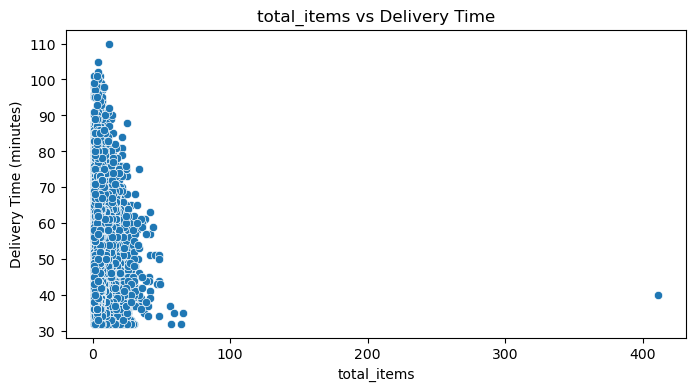

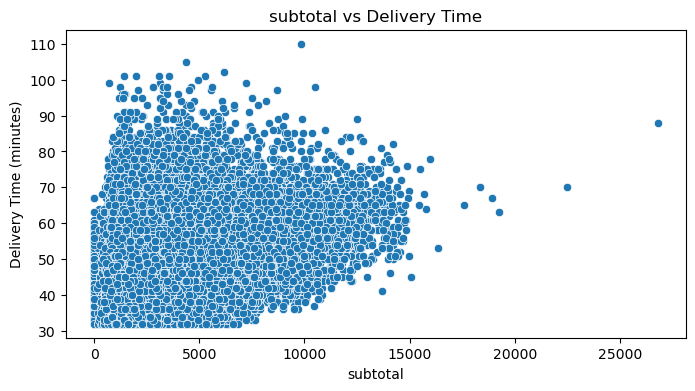

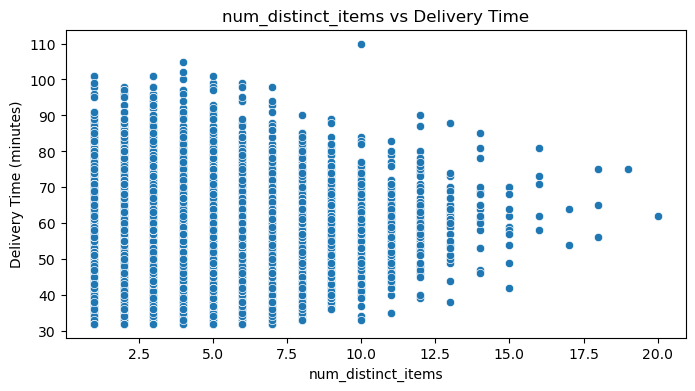

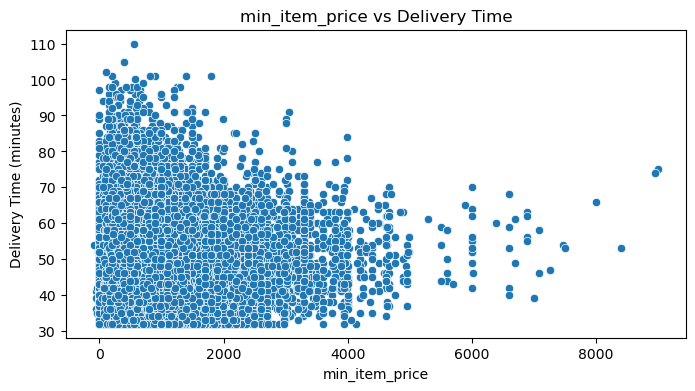

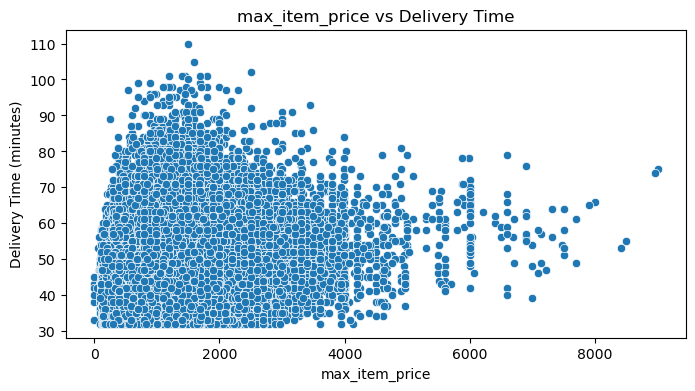

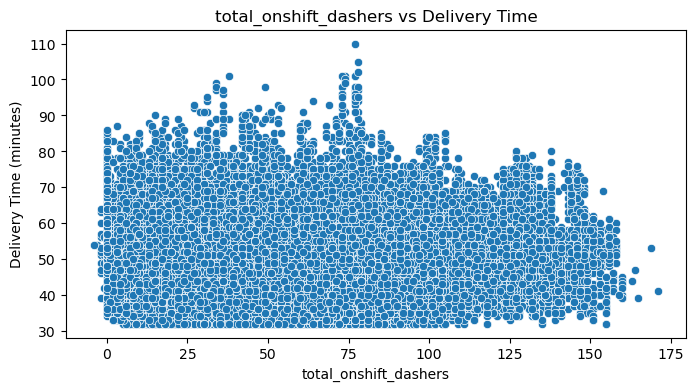

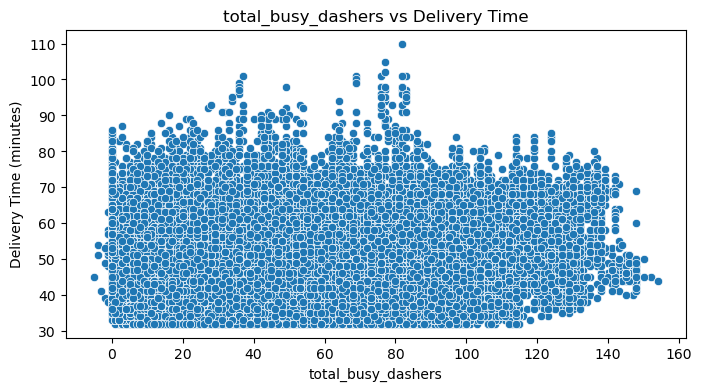

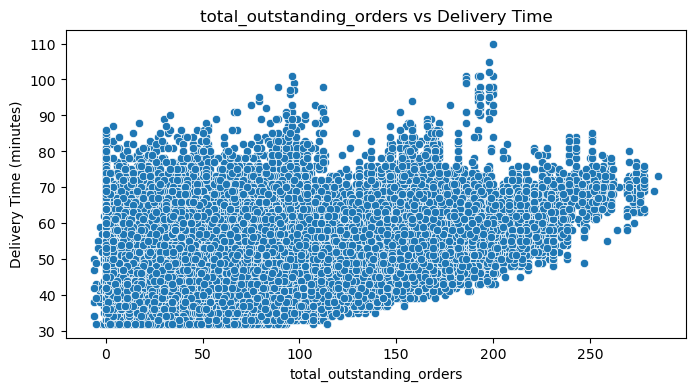

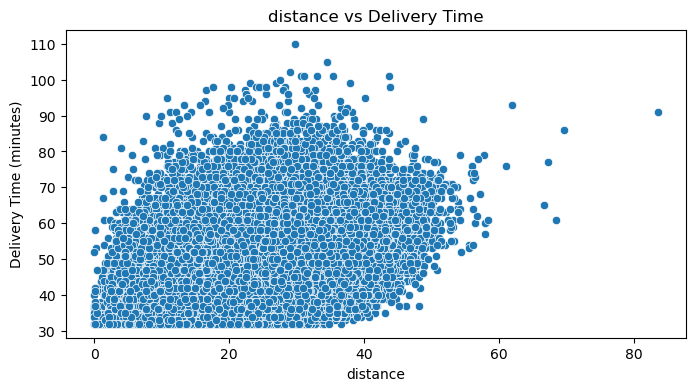

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features
# Scatter plots of numerical features vs target
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=X_train[col], y=y_train)
    plt.title(f'{col} vs Delivery Time')
    plt.xlabel(col)
    plt.ylabel('Delivery Time (minutes)')
    plt.show()




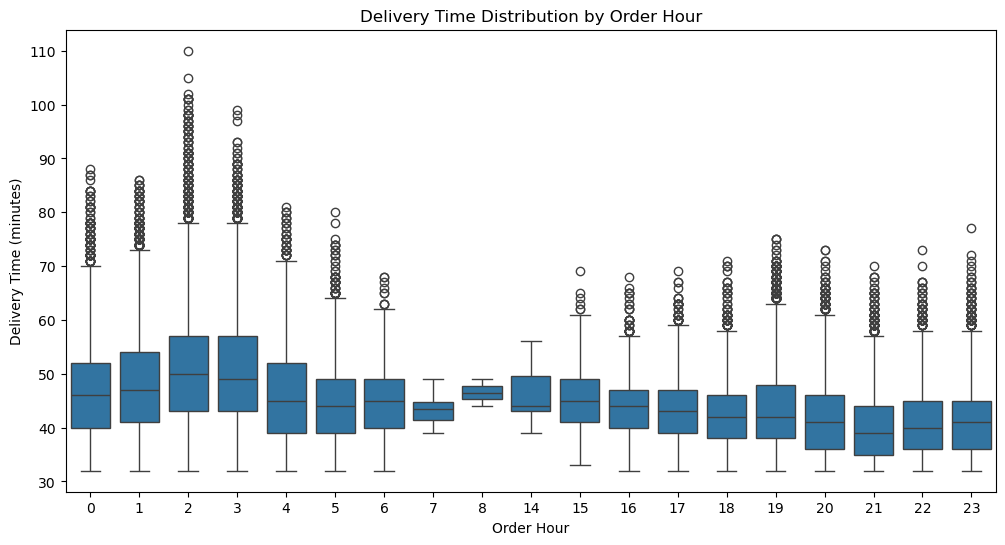

In [ ]:
# Show the distribution of time_taken for different hours
plt.figure(figsize=(12, 6))
sns.boxplot(x=X_train['order_hour'], y=y_train)
plt.title('Delivery Time Distribution by Order Hour')
plt.xlabel('Order Hour')
plt.ylabel('Delivery Time (minutes)')
plt.show()



#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

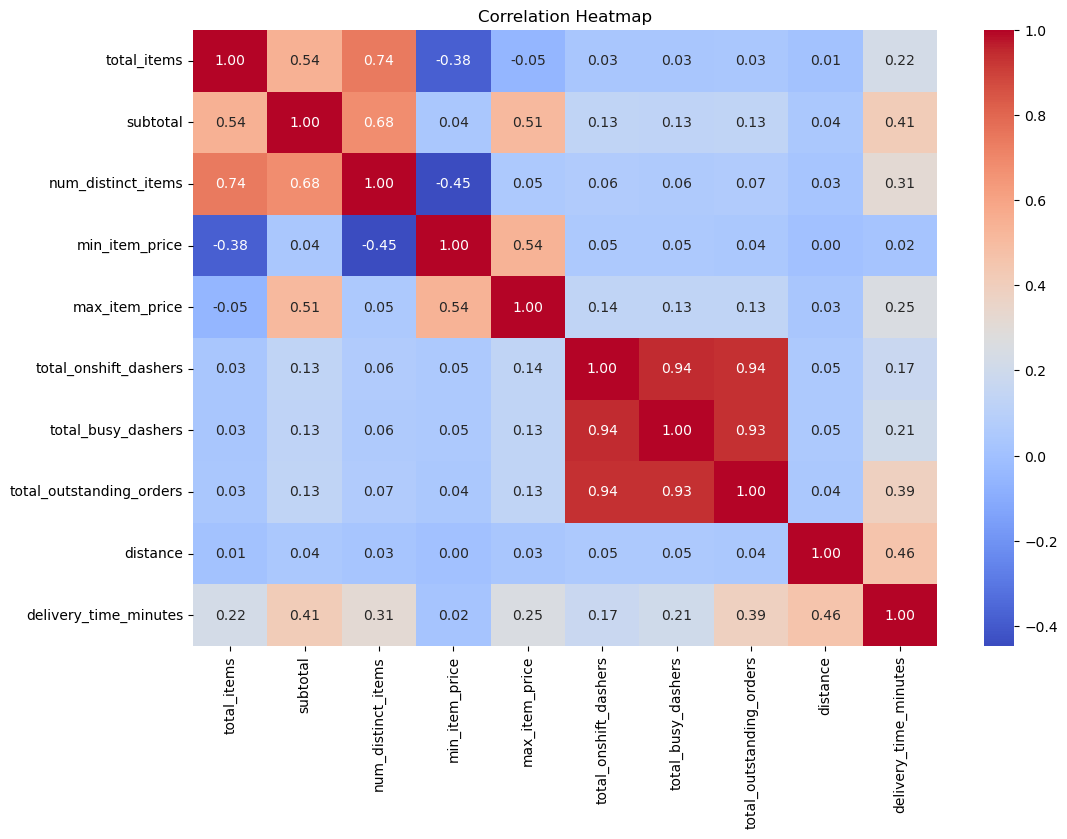

In [ ]:
# Plot the heatmap of the correlation matrix
# Combine numerical features and target for correlation
corr_matrix = pd.concat([X_train[num_cols], y_train], axis=1).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()




##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [ ]:
# Drop 3-5 weakly correlated columns from training dataset
# Example: dropping weakly correlated columns (replace with actual weak columns from your heatmap)
weak_cols = ['min_item_price', 'max_item_price', 'num_distinct_items']  # replace based on your analysis

# Drop from training and testing sets
X_train = X_train.drop(weak_cols, axis=1)
X_test = X_test.drop(weak_cols, axis=1)

# Update numerical and categorical lists
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

print("Updated features:", X_train.columns.tolist())




Updated features: ['market_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_hour', 'order_day_of_week', 'isWeekend']


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

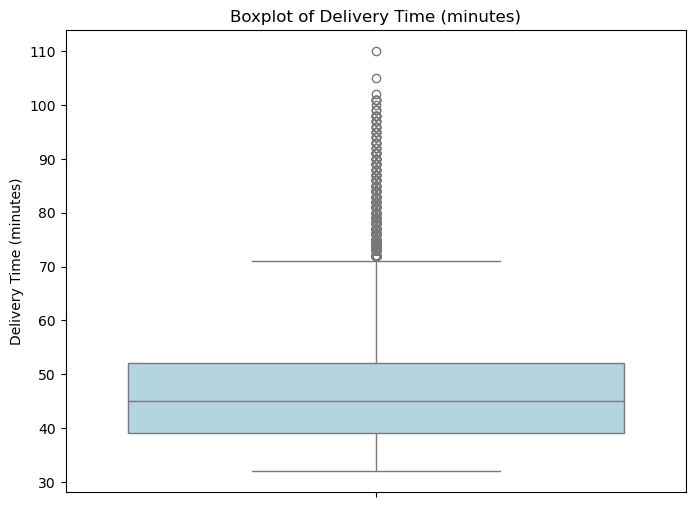

In [ ]:
# Boxplot for time_taken
plt.figure(figsize=(8, 6))
sns.boxplot(y=y_train, color='lightblue')
plt.title('Boxplot of Delivery Time (minutes)')
plt.ylabel('Delivery Time (minutes)')
plt.show()



##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [ ]:
# Handle outliers




In [ ]:
# Handle outliers
# Function to remove outliers using IQR
def remove_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
    return df

# Apply outlier handling to numerical features
X_train = remove_outliers(X_train, num_cols)
X_test = remove_outliers(X_test, num_cols)
y_train = remove_outliers(pd.DataFrame(y_train), ['delivery_time_minutes'])['delivery_time_minutes']
y_test = remove_outliers(pd.DataFrame(y_test), ['delivery_time_minutes'])['delivery_time_minutes']


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation
# Numerical columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical columns
cat_cols = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)



Numerical columns: ['total_items', 'subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']
Categorical columns: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']


#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

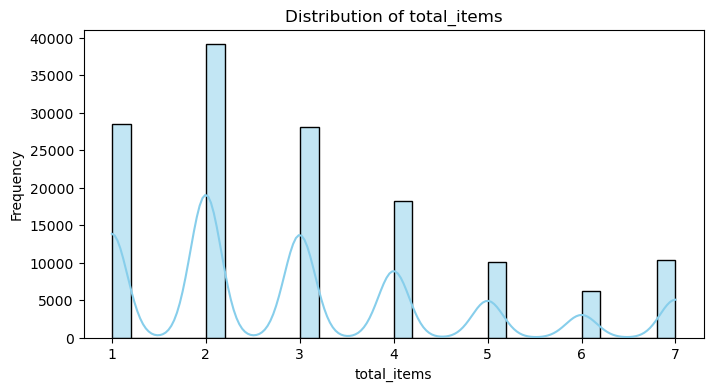

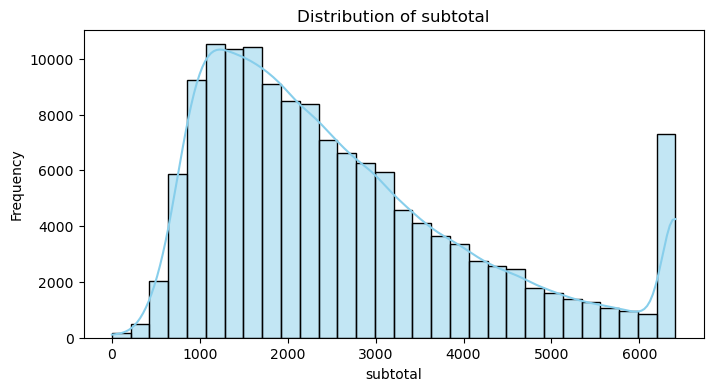

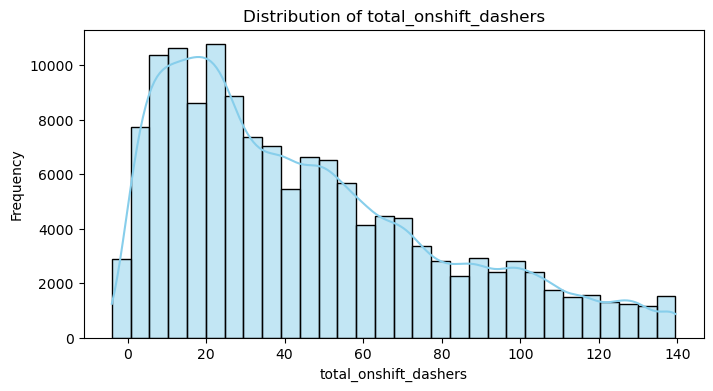

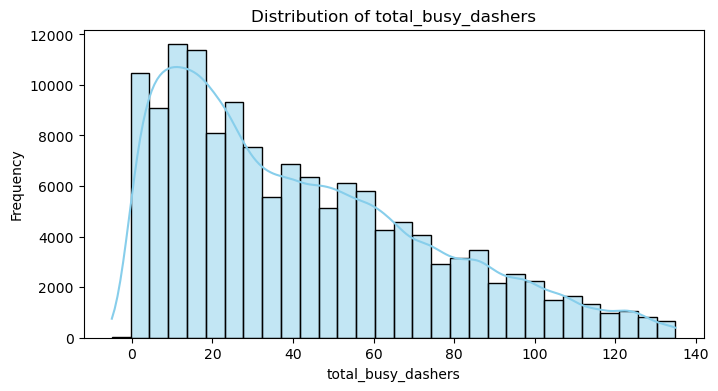

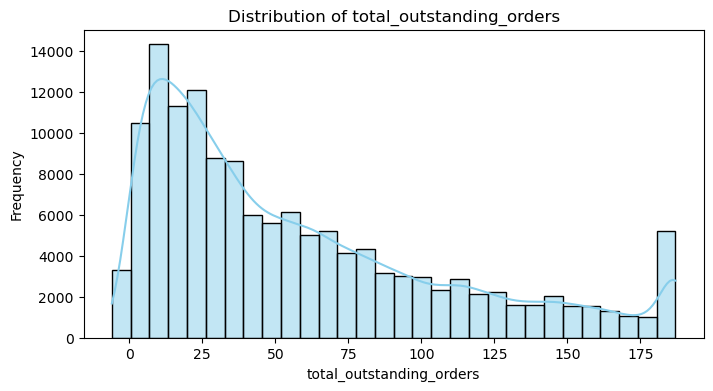

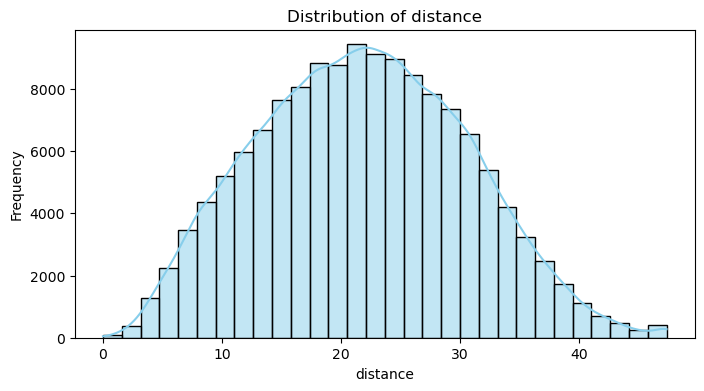

In [ ]:
# Plot distributions for all numerical columns
# Plot distributions for numerical columns
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(X_train[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


##### **4.1.2**
Check the distribution of categorical features

C:\Users\Karthik\AppData\Local\Temp\ipykernel_35908\824462089.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=X_train, x=col, order=X_train[col].value_counts().index, palette='pastel')


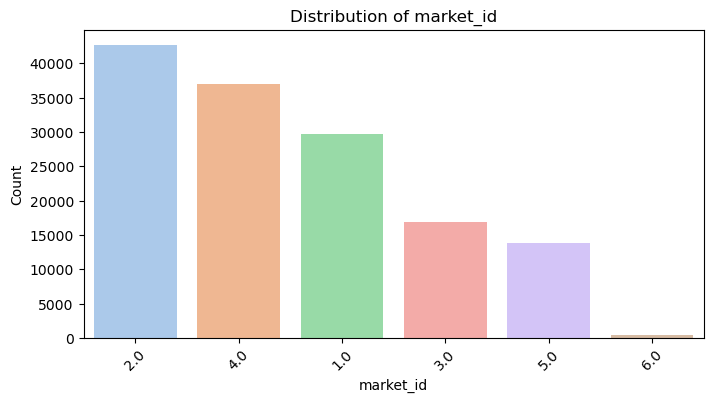

C:\Users\Karthik\AppData\Local\Temp\ipykernel_35908\824462089.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=X_train, x=col, order=X_train[col].value_counts().index, palette='pastel')


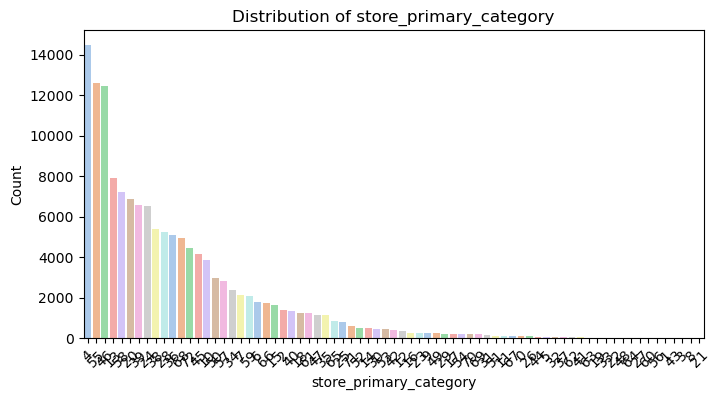

C:\Users\Karthik\AppData\Local\Temp\ipykernel_35908\824462089.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=X_train, x=col, order=X_train[col].value_counts().index, palette='pastel')


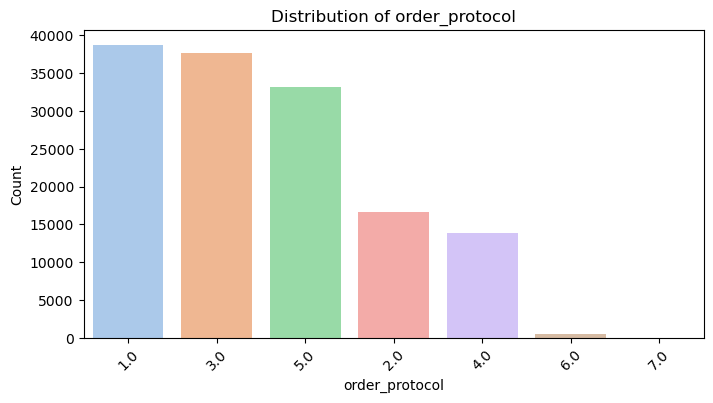

C:\Users\Karthik\AppData\Local\Temp\ipykernel_35908\824462089.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=X_train, x=col, order=X_train[col].value_counts().index, palette='pastel')


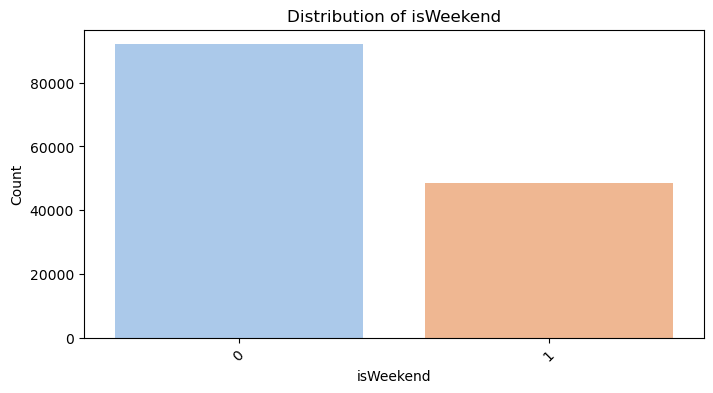

In [ ]:
# Distribution of categorical columns
# Plot distributions for categorical columns
for col in cat_cols:
      plt.figure(figsize=(8, 4))
      sns.countplot(data=X_train, x=col, order=X_train[col].value_counts().index, palette='pastel')
      plt.title(f'Distribution of {col}')
      plt.xlabel(col)
      plt.ylabel('Count')
      plt.xticks(rotation=45)
      plt.show()



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

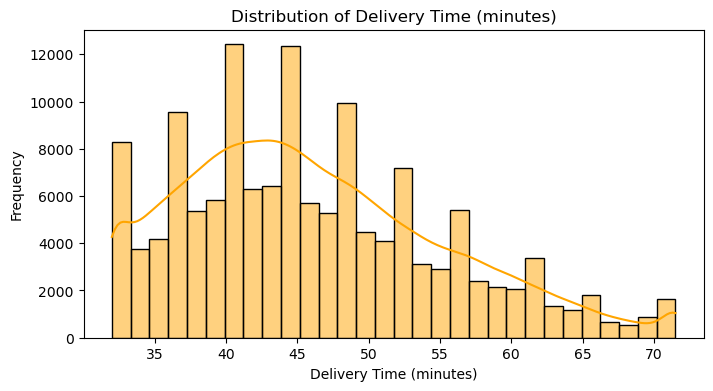

In [ ]:
# Distribution of time_taken
  plt.figure(figsize=(8, 4))
  sns.histplot(y_train, kde=True, bins=30, color='orange')
  plt.title('Distribution of Delivery Time (minutes)')
  plt.xlabel('Delivery Time (minutes)')
  plt.ylabel('Frequency')
  plt.show()


#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

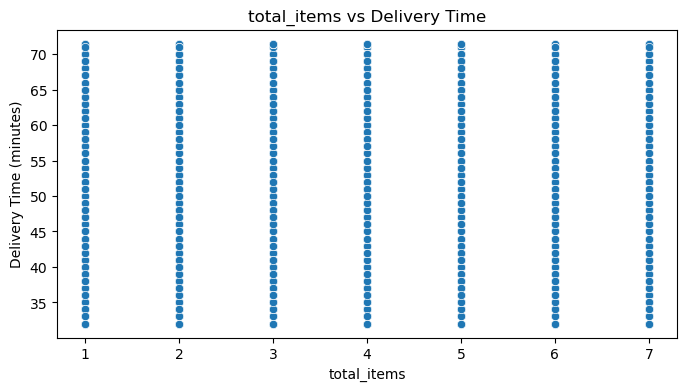

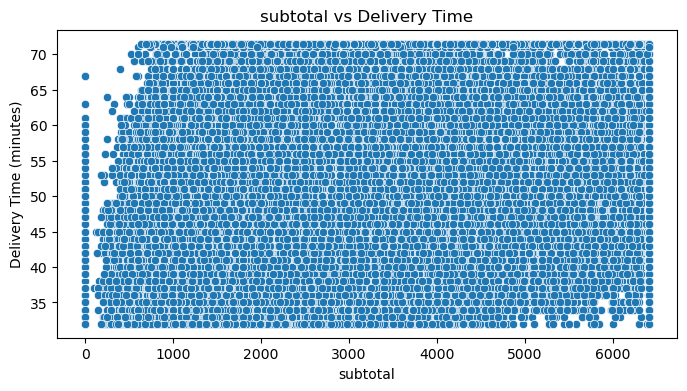

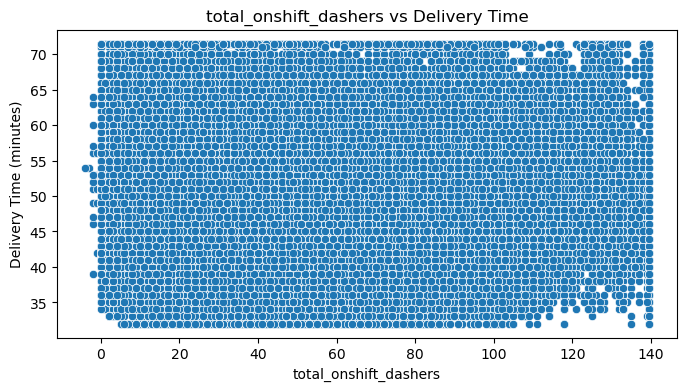

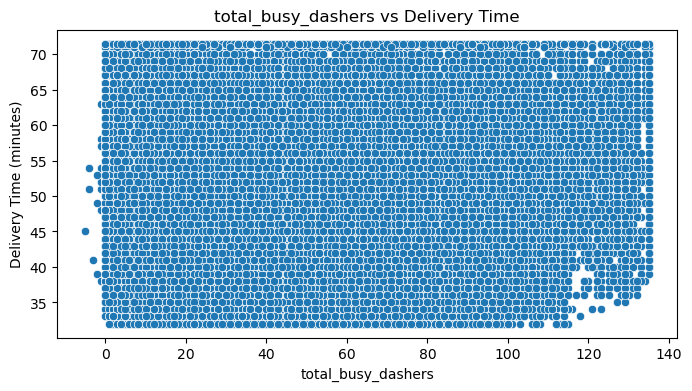

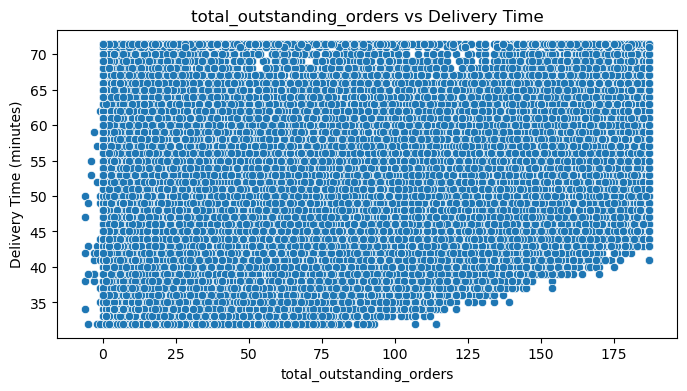

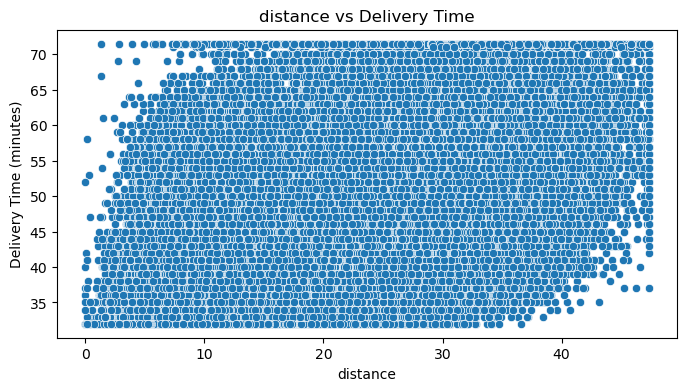

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features
# Scatter plots of numerical features vs target
  for col in num_cols:
      plt.figure(figsize=(8, 4))
      sns.scatterplot(x=X_train[col], y=y_train)
      plt.title(f'{col} vs Delivery Time')
      plt.xlabel(col)
      plt.ylabel('Delivery Time (minutes)')
      plt.show()




#### **4.3** Drop the columns with weak correlations with the target variable

In [ ]:
# Drop the weakly correlated columns from training dataset

corr = train_df[num_cols].corr()['time_taken'].sort_values()
print(corr)

weak_cols = corr[abs(corr) < 0.05].index.tolist()


print("Weakly correlated columns:", weak_cols)
# Drop them from train_df
train_df = train_df.drop(columns=weak_cols)


total_onshift_dashers       0.052195
total_busy_dashers          0.087774
isWeekend                   0.121133
max_item_price              0.214285
total_items                 0.226694
num_distinct_items          0.249057
total_outstanding_orders    0.272142
subtotal                    0.340785
distance                    0.501302
time_taken                  1.000000
Name: time_taken, dtype: float64
Weakly correlated columns: []


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [ ]:
# Import libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [ ]:
# Apply scaling to the numerical columns
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both training and testing sets
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Check the scaled features
X_train.head()



,market_id,store_primary_category,order_protocol,total_items,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance,order_hour,order_day_of_week,isWeekend
102712,2.0,45,2.0,-1.149075,-1.166865,-0.286914,-0.089125,-0.030878,0.971786,21,1,0
94576,4.0,20,3.0,-1.149075,-1.052738,1.891894,0.937172,1.149937,1.067993,2,4,0
49784,1.0,36,3.0,0.559700,-0.371242,-1.129387,-1.208721,-0.995211,-0.420926,21,4,0
37753,3.0,39,1.0,-0.579483,-0.152120,-0.838879,-0.773323,-0.759048,1.329126,3,1,0
91728,2.0,6,1.0,-1.149075,-0.769053,0.555558,0.159675,-0.109599,1.113806,21,4,0


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [ ]:
# Create/Initialise the model
# Initialize Linear Regression model
lr_model = LinearRegression()

# Fit the model on training data
lr_model.fit(X_train, y_train)

# Check the model coefficients
print("Intercept:", lr_model.intercept_)
print("Coefficients:", dict(zip(X_train.columns, lr_model.coef_)))


Intercept: 51.47393559842932
Coefficients: {'market_id': -0.6299452191484269, 'store_primary_category': 0.004012163665802073, 'order_protocol': -0.7091172989630019, 'total_items': 0.38449150884639477, 'subtotal': 2.5940150443186436, 'total_onshift_dashers': -12.503828552742547, 'total_busy_dashers': -4.4044434058042246, 'total_outstanding_orders': 18.10142020150677, 'distance': 4.113615451283575, 'order_hour': -0.23714857374946582, 'order_day_of_week': -0.11786929547154638, 'isWeekend': 2.0414923994352088}


In [ ]:
# Train the model using the training data
# Fit the Linear Regression model on training data
lr_model.fit(X_train, y_train)

# Make predictions on training data
y_train_pred = lr_model.predict(X_train)

# Evaluate on training data
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f"Training MSE: {mse:.2f}")
print(f"Training MAE: {mae:.2f}")
print(f"Training R^2 Score: {r2:.2f}")


Training MSE: 11.25
Training MAE: 2.47
Training R^2 Score: 0.86


In [ ]:
# Make predictions
# Make predictions on the test data
y_test_pred = lr_model.predict(X_test)

# Evaluate model performance on test data
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test MSE: {mse_test:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Test R^2 Score: {r2_test:.2f}")



Test MSE: 10.94
Test MAE: 2.45
Test R^2 Score: 0.87


In [ ]:
# Find results for evaluation metrics
# Training data evaluation
  y_train_pred = lr_model.predict(X_train)
  train_mse = mean_squared_error(y_train, y_train_pred)
  train_mae = mean_absolute_error(y_train, y_train_pred)
  train_r2 = r2_score(y_train, y_train_pred)

# Test data evaluation
  y_test_pred = lr_model.predict(X_test)
  test_mse = mean_squared_error(y_test, y_test_pred)
  test_mae = mean_absolute_error(y_test, y_test_pred)
  test_r2 = r2_score(y_test, y_test_pred)

# Display the results

  print("=== Training Set Metrics ===")
  print(f"MSE: {train_mse:.2f}")
  print(f"MAE: {train_mae:.2f}")
  print(f"R^2 Score: {train_r2:.2f}\n")

  print("=== Test Set Metrics ===")
  print(f"MSE: {test_mse:.2f}")
  print(f"MAE: {test_mae:.2f}")
  print(f"R^2 Score: {test_r2:.2f}")


=== Training Set Metrics ===
MSE: 11.25
MAE: 2.47
R^2 Score: 0.86

=== Test Set Metrics ===
MSE: 10.94
MAE: 2.45
R^2 Score: 0.87


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

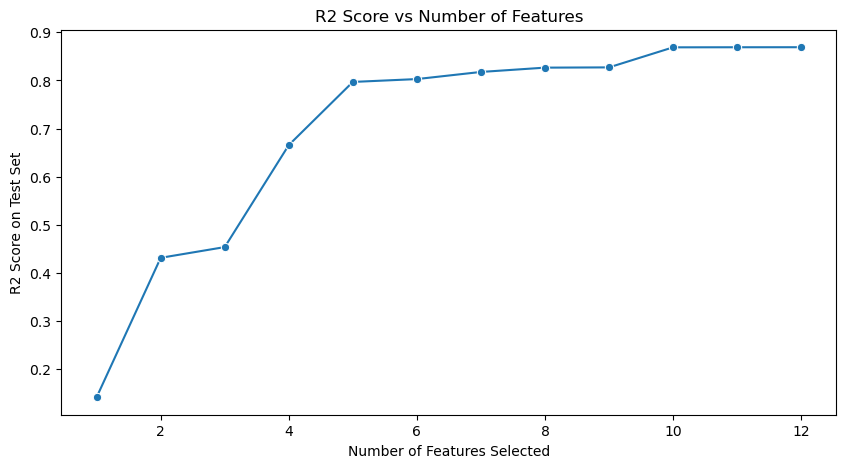

In [ ]:
# Loop through the number of features and test the model
from sklearn.feature_selection import RFE

# Initialize linear regression
lr = LinearRegression()

# Store results
rfe_results = []

# Loop through 1 to total number of features
for n_features in range(1, X_train.shape[1]+1):
    # Initialize RFE with n_features
    rfe = RFE(estimator=lr, n_features_to_select=n_features)

    # Fit RFE
    rfe.fit(X_train, y_train)

    # Transform training and test sets
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    # Fit linear regression on selected features
    lr.fit(X_train_rfe, y_train)
    y_test_pred = lr.predict(X_test_rfe)

    # Evaluate
    r2 = r2_score(y_test, y_test_pred)
    rfe_results.append((n_features, r2))

# Convert results to DataFrame for easy visualization
    rfe_df = pd.DataFrame(rfe_results, columns=['Num_Features', 'R2_Score'])

# Plot R2 vs number of features
    plt.figure(figsize=(10,5))
    sns.lineplot(x='Num_Features', y='R2_Score', data=rfe_df, marker='o')
    plt.title('R2 Score vs Number of Features')
    plt.xlabel('Number of Features Selected')
    plt.ylabel('R2 Score on Test Set')
    plt.show()



In [ ]:
# Build the final model with selected number of features
# Suppose the optimal number of features from RFE is 8
optimal_features = 8

# Initialize RFE with optimal number of features
rfe_final = RFE(estimator=LinearRegression(), n_features_to_select=optimal_features)

# Fit RFE on training data
rfe_final.fit(X_train, y_train)

# Transform training and test data to select only important features
X_train_final = rfe_final.transform(X_train)
X_test_final = rfe_final.transform(X_test)

# Build and train the final Linear Regression model
final_model = LinearRegression()
final_model.fit(X_train_final, y_train)

# Make predictions
y_test_final_pred = final_model.predict(X_test_final)

# Evaluate the final model
mse_final = mean_squared_error(y_test, y_test_final_pred)
mae_final = mean_absolute_error(y_test, y_test_final_pred)
r2_final = r2_score(y_test, y_test_final_pred)

print("=== Final Model Performance ===")
print(f"MSE: {mse_final:.2f}")
print(f"MAE: {mae_final:.2f}")
print(f"R^2 Score: {r2_final:.2f}")

# Show which features were selected
selected_features = X_train.columns[rfe_final.support_]
print("Selected Features:", list(selected_features))



=== Final Model Performance ===
MSE: 14.48
MAE: 2.89
R^2 Score: 0.83
Selected Features: ['market_id', 'order_protocol', 'subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'isWeekend']


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

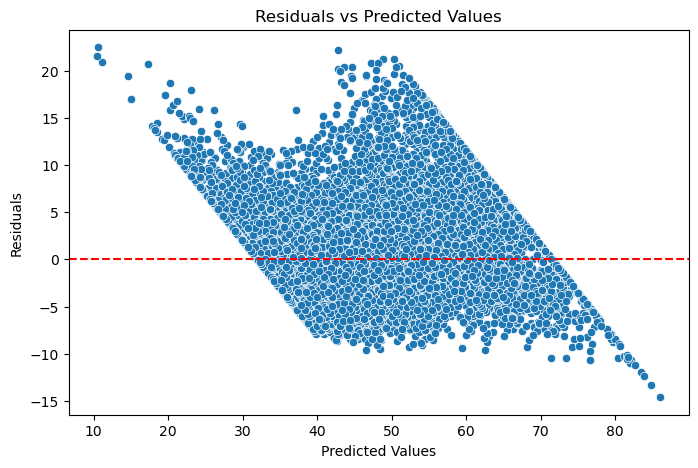

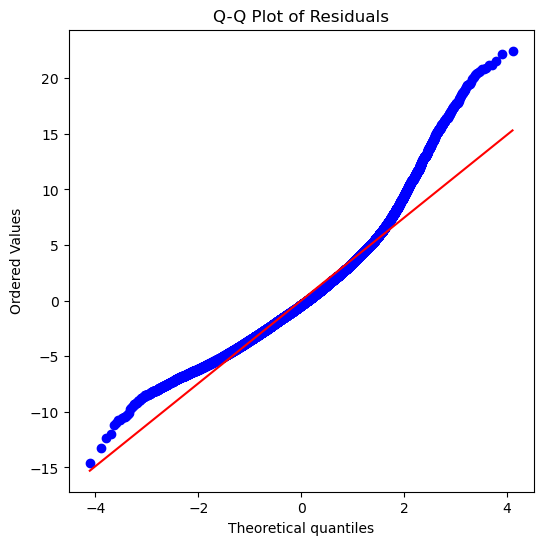

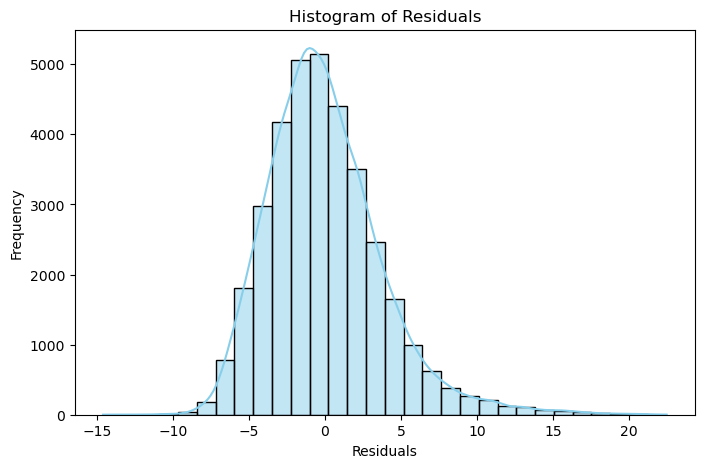

In [ ]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Calculate residuals
residuals = y_test - y_test_final_pred

# 1. Residuals vs Predicted Values
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test_final_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

# 2. Q-Q Plot to check normality of residuals
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# 3. Residual Histogram
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=30, color='skyblue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [ ]:
# Compare the scaled vs unscaled features used in the final model
# Get selected feature names
selected_features = X_train.columns[rfe_final.support_]

# Coefficients from final model (trained on scaled data)
scaled_coefficients = final_model.coef_

# Display scaled coefficients alongside feature names
scaled_df = pd.DataFrame({
    'Feature': selected_features,
    'Scaled_Coefficient': scaled_coefficients
})
print("Scaled Feature Coefficients:")
print(scaled_df)

# If you want to compare with unscaled features:

# Refit model on unscaled selected features
X_train_unscaled = X_train[selected_features]
X_test_unscaled = X_test[selected_features]

unscaled_model = LinearRegression()
unscaled_model.fit(X_train_unscaled, y_train)
unscaled_coefficients = unscaled_model.coef_

unscaled_df = pd.DataFrame({
    'Feature': selected_features,
    'Unscaled_Coefficient': unscaled_coefficients
})
print("\nUnscaled Feature Coefficients:")
print(unscaled_df)

# Optional: Combine for side-by-side comparison
comparison_df = scaled_df.merge(unscaled_df, on='Feature')
print("\nComparison of Scaled vs Unscaled Coefficients:")
print(comparison_df)



Scaled Feature Coefficients:
                    Feature  Scaled_Coefficient
0                 market_id           -0.655860
1            order_protocol           -0.771654
2                  subtotal            3.189492
3     total_onshift_dashers          -11.963744
4        total_busy_dashers           -4.561605
5  total_outstanding_orders           18.461060
6                  distance            4.117021
7                 isWeekend            1.439181

Unscaled Feature Coefficients:
                    Feature  Unscaled_Coefficient
0                 market_id             -0.655860
1            order_protocol             -0.771654
2                  subtotal              3.189492
3     total_onshift_dashers            -11.963744
4        total_busy_dashers             -4.561605
5  total_outstanding_orders             18.461060
6                  distance              4.117021
7                 isWeekend              1.439181

Comparison of Scaled vs Unscaled Coefficients:
         

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [ ]:
# Analyze the effect of a unit change in a feature, say 'total_items'
# Feature to analyze
# Check selected features in the final model
selected_features = X_train.columns[rfe_final.support_]
print("Selected features in the final model:")
print(list(selected_features))

# Pick one feature from the selected features list, e.g., the first one
feature_name = selected_features[0]

# Get the coefficient from the unscaled model
feature_index = list(X_train_unscaled.columns).index(feature_name)
coef_value = unscaled_model.coef_[feature_index]

print(f"Effect of 1 unit increase in '{feature_name}':")
print(f"Time_taken changes by {coef_value:.2f} minutes on average, holding other features constant.")





Selected features in the final model:
['market_id', 'order_protocol', 'subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'isWeekend']
Effect of 1 unit increase in 'market_id':
Time_taken changes by -0.66 minutes on average, holding other features constant.


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
> Yes



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
> test_size = 0.2 means that 20% of the dataset will be set aside as the test set, while the remaining 80% will be used for training.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
> The feature with the highest correlation to the target variable is Distance.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**
> I used the IQR method to identify outliers beyond
𝑄
1
−
1.5
×
𝐼
𝑄
𝑅
 and
𝑄
3
+
1.5
×
𝐼
𝑄
𝑅
. Outliers in numerical columns were capped in upper and lower bounds.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
> The top three feature affecting the deilivery time are:

Distance – Longer travel distances significantly increase delivery duration.

Order volume (total_items or subtotal) – Larger or more complex orders require more prep and handling time.

Dasher demand (busy_dashers or outstanding_orders) – High demand leads to delays due to limited delivery capacity.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
> Linear regression is a supervised learning algorithm that models the relationship between a dependent variable and one or more independent variables using a linear equation. It predicts outcomes using the formula
𝑌
=
𝛽
0
+
𝛽
1
𝑋
1
+
𝛽
2
𝑋
2
+
⋯
+
𝛽
𝑛
𝑋
𝑛
. The model learns the optimal coefficients by minimizing the sum of squared errors between predicted and actual values. It assumes a linear relationship and aims to fit the best possible line through the data points.




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
> Simple linear regression uses one independent variable to predict a dependent variable. It assumes a straight-line relationship between the two variables and is easy to interpret and visualize. It is mainly used when one factor influences the outcome.

Multiple linear regression uses two or more independent variables to predict a dependent variable. It helps understand the combined effect of multiple factors on the outcome and is more suitable for complex, real-world problems where many variables influence results.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
> The cost function in linear regression measures the difference between predicted and actual values, and it is minimized using gradient descent, which iteratively updates the coefficients to reduce error.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**
> Cost function - Measures how far predictions are from actual values (the error).

Gradient descent - Optimization method that minimizes the cost function by adjusting model coefficients.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
> Residual plots help by showing whether the assumptions of linear regression are valid. They reveal if errors are randomly distributed, constant in variance, and independent, which indicates a good model fit.